All Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from collections import Counter
from nltk.corpus import stopwords

import textwrap

Create all Databases

In [2]:
# Lines per character
df = pd.read_csv("../output/friends_dialogues.csv")

In [3]:
# Episode information, including ratings per episode
ep_data = pd.read_csv("../output/friends_episode_ratings.csv")

In [4]:
# All scenes by character
scenes_data = pd.read_csv("../output/character_scene_counts.csv")

In [5]:
# Scenes by character by episode
scenes_by_ep = pd.read_csv("../output/character_scene_counts_by_episode.csv")

Data Cleaning


In [6]:
# Name Processing

df["Character"] = df["Character"].str.capitalize()
scenes_data["Character"] = scenes_data["Character"].str.capitalize()
scenes_by_ep["Character"] = scenes_by_ep["Character"].str.capitalize()

typo_corrections = {
    'Chan': 'Chandler',
    'Gunter': 'Gunther',
    'Mnca': 'Monica',
    'Rach': 'Rachel',
    'Phoe': 'Phoebe',
    'Racel': 'Rachel',
    'Rache': 'Rachel'
}

df['Character'] = df['Character'].replace(typo_corrections)
scenes_by_ep['Character'] = scenes_by_ep['Character'].replace(typo_corrections)

In [7]:
# Main Characters Extraction
main_characters = ['Chandler', 'Joey', 'Monica', 'Rachel', 'Ross', 'Phoebe']
df_main_characters = df[df['Character'].isin(main_characters)]
scenes_main_characters = scenes_by_ep[scenes_by_ep['Character'].isin(main_characters)]

Character Lines by Season

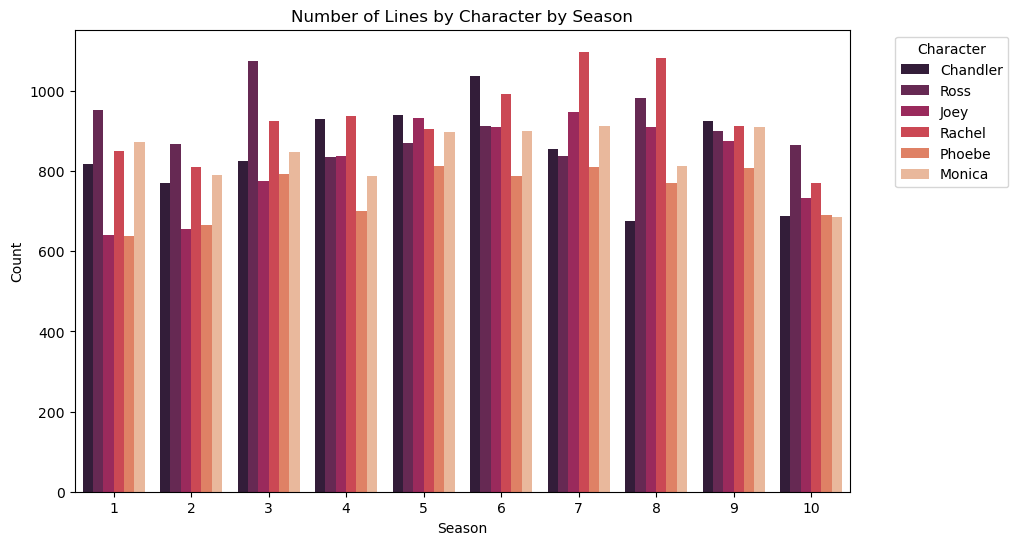

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_main_characters, x='Season', hue='Character', palette='rocket')
plt.title('Number of Lines by Character by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.legend(title='Character', bbox_to_anchor=(1.05, 1), loc='upper left')

Character Scenes by Season

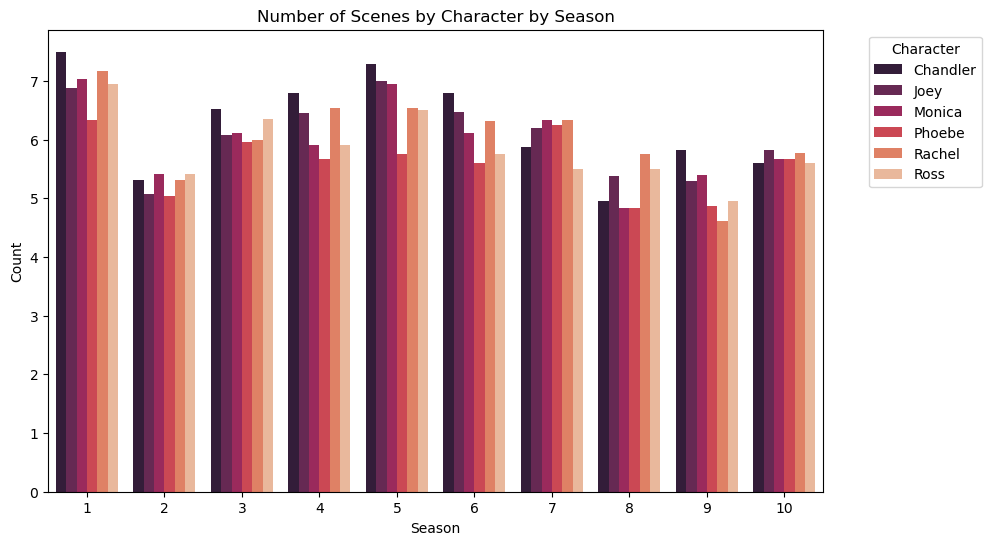

In [9]:
## Plot of Scene Count by Character per Season
plt.figure(figsize=(10, 6))
sns.barplot(data=scenes_main_characters, x='Season', y='Scene Count', hue='Character', palette='rocket', errorbar=None)
plt.title('Number of Scenes by Character by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.legend(title='Character', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Lines vs. Scenes

In [10]:
# Data Processing:
lines_main_characters = df_main_characters.groupby(['Season', 'Episode', 'Character'])['Lines'].count().reset_index()
lines_vs_scenes = lines_main_characters.merge(scenes_main_characters, on=['Season', 'Episode', 'Character'], suffixes=('_lines', '_scenes'))

In [11]:
# Lines & scenes summed up per season
lines_vs_scenes_by_season = lines_vs_scenes.groupby(['Season', 'Character'])[['Lines', 'Scene Count']].sum().reset_index()

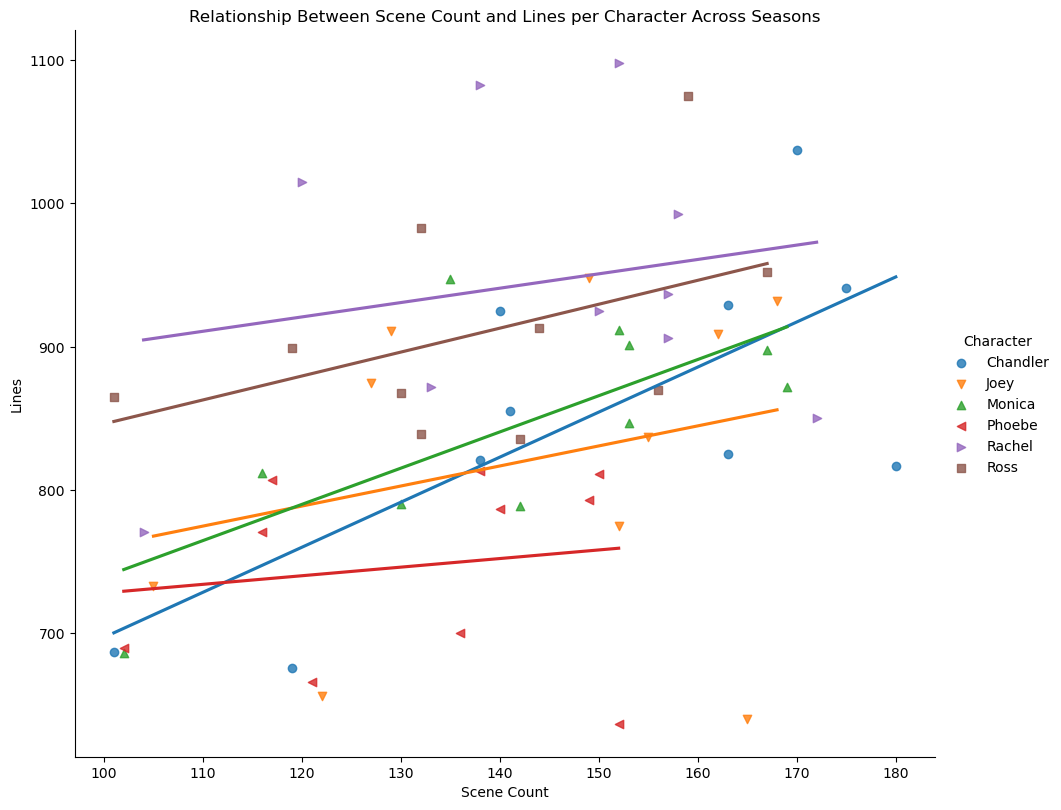

In [12]:
# Plot Lines vs. Scenes per Character per Season:
# Set plot size and style
# Create a scatter plot with trend lines for each character
sns.lmplot(data=lines_vs_scenes_by_season, x='Scene Count', y='Lines', hue='Character',
           markers=['o', 'v', '^', '<', '>', 's'], # Custom markers for each character
           palette='tab10', height=8, aspect=1.2, ci=None) # Suppressing confidence intervals

# Customize the plot
plt.title('Relationship Between Scene Count and Lines per Character Across Seasons')
plt.xlabel('Scene Count')
plt.ylabel('Lines')

# Show plot
plt.show()

Character Sentiment by Season:

In [13]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df_main_characters = df_main_characters.copy()
df_main_characters['Sentiment'] = df_main_characters['Lines'].apply(get_sentiment)

In [14]:
# Group by season and character to calculate average sentiment
sentiment_by_season = df_main_characters.groupby(['Season', 'Character'])['Sentiment'].mean().reset_index()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


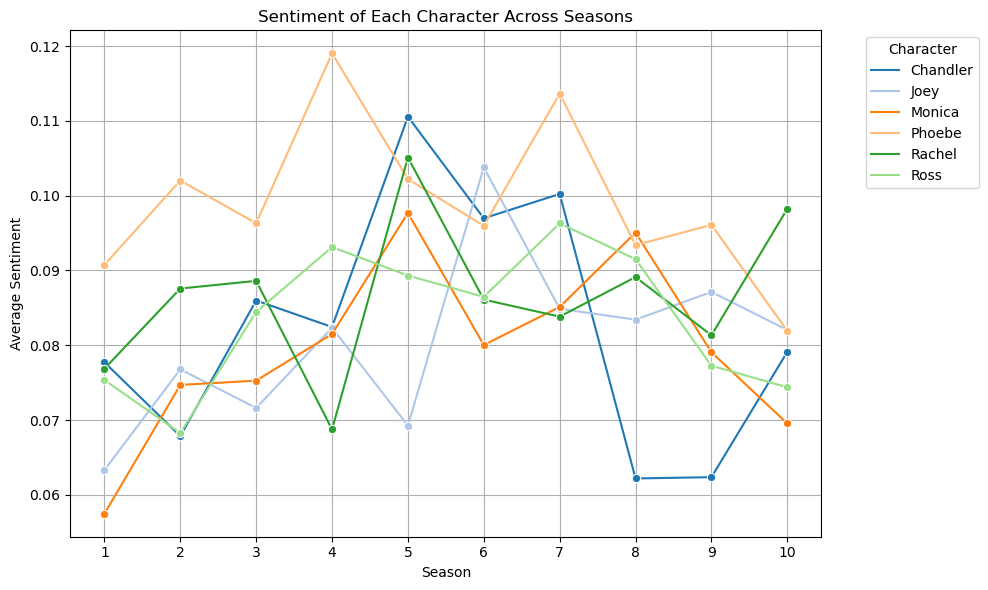

In [15]:
# Plotting the sentiment for each character across seasons
plt.figure(figsize=(10, 6))
sns.lineplot(data=sentiment_by_season, x='Season', y='Sentiment', hue='Character', marker='o', palette='tab20')

# Customize the plot
plt.title('Sentiment of Each Character Across Seasons')
plt.xlabel('Season')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.legend(title='Character', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(ticks=sentiment_by_season['Season'].unique())

# Show the plot
plt.show()

Most positive and most negative main character overall:
Is there an actual difference between their sentiment?

In [16]:
# 1. Perform ANOVA to see if there's a significant difference in sentiment between characters
anova_results = ols('Sentiment ~ Character', data=df_main_characters).fit()
anova_table = sm.stats.anova_lm(anova_results, typ=2)
print("ANOVA results:\n", anova_table)

ANOVA results:
                 sum_sq       df         F    PR(>F)
Character     1.922840      5.0  4.792989  0.000221
Residual   4088.159684  50952.0       NaN       NaN


In [17]:
# 2. Post-hoc analysis

if anova_table['PR(>F)'][0] < 0.05:
    # 2. Perform Tukey's HSD test for post-hoc comparison
    tukey = pairwise_tukeyhsd(endog=df_main_characters['Sentiment'], groups=df_main_characters['Character'], alpha=0.05)
    print("\nTukey HSD results:\n", tukey)

/var/folders/5j/72hr1c256kqg4q371dg_rv340000gn/T/ipykernel_1967/4161275430.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:



Tukey HSD results:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Chandler   Joey  -0.0024 0.9938 -0.0149  0.0101  False
Chandler Monica  -0.0038 0.9509 -0.0163  0.0086  False
Chandler Phoebe   0.0157 0.0064  0.0029  0.0285   True
Chandler Rachel   0.0027 0.9877 -0.0094  0.0149  False
Chandler   Ross     -0.0    1.0 -0.0122  0.0122  False
    Joey Monica  -0.0014 0.9996 -0.0139  0.0111  False
    Joey Phoebe   0.0181 0.0009  0.0052   0.031   True
    Joey Rachel   0.0052 0.8342 -0.0071  0.0174  False
    Joey   Ross   0.0024 0.9934 -0.0099  0.0147  False
  Monica Phoebe   0.0195 0.0002  0.0067  0.0324   True
  Monica Rachel   0.0066 0.6356 -0.0056  0.0187  False
  Monica   Ross   0.0038 0.9482 -0.0084   0.016  False
  Phoebe Rachel  -0.0129 0.0383 -0.0255 -0.0004   True
  Phoebe   Ross  -0.0157 0.0051 -0.0283 -0.0031   True
  Rachel   Ross  -0.0028 0.9863 -0.0147  0.0

In [18]:
# 3. Rank characters by their overall average sentiment
character_ranking = df_main_characters.groupby('Character')['Sentiment'].mean().sort_values(ascending=False)
print("\nCharacter ranking by overall sentiment:\n", character_ranking)


Character ranking by overall sentiment:
 Character
Phoebe      0.099307
Rachel      0.086357
Chandler    0.083620
Ross        0.083602
Joey        0.081183
Monica      0.079774
Name: Sentiment, dtype: float64


In [19]:
# 4. Display ranks
df_ranks = pd.DataFrame(character_ranking).reset_index()
df_ranks['Rank'] = df_ranks['Sentiment'].rank(ascending=False)
print("\nRanked characters by sentiment:\n", df_ranks)


Ranked characters by sentiment:
   Character  Sentiment  Rank
0    Phoebe   0.099307   1.0
1    Rachel   0.086357   2.0
2  Chandler   0.083620   3.0
3      Ross   0.083602   4.0
4      Joey   0.081183   5.0
5    Monica   0.079774   6.0


Ratings data analysis

In [20]:
# RUN THIS ONLY ONCE
# Calculate the average rating per season and merge with the main dataframe
average_rating_per_season = ep_data.groupby('Season')['Stars'].mean().reset_index()
ep_data = ep_data.merge(average_rating_per_season, on='Season', suffixes=('', '_avg'))

In [21]:
# Sort data to get the top 5 and bottom 5 episodes by rating
top_5_episodes = ep_data.nlargest(5, 'Stars')
bottom_5_episodes = ep_data.nsmallest(5, 'Stars')

In [22]:
# Helper function for the graph
def wrap_text(text, width=20):
    return '\n'.join(textwrap.wrap(text, width))

<Figure size 1200x600 with 0 Axes>

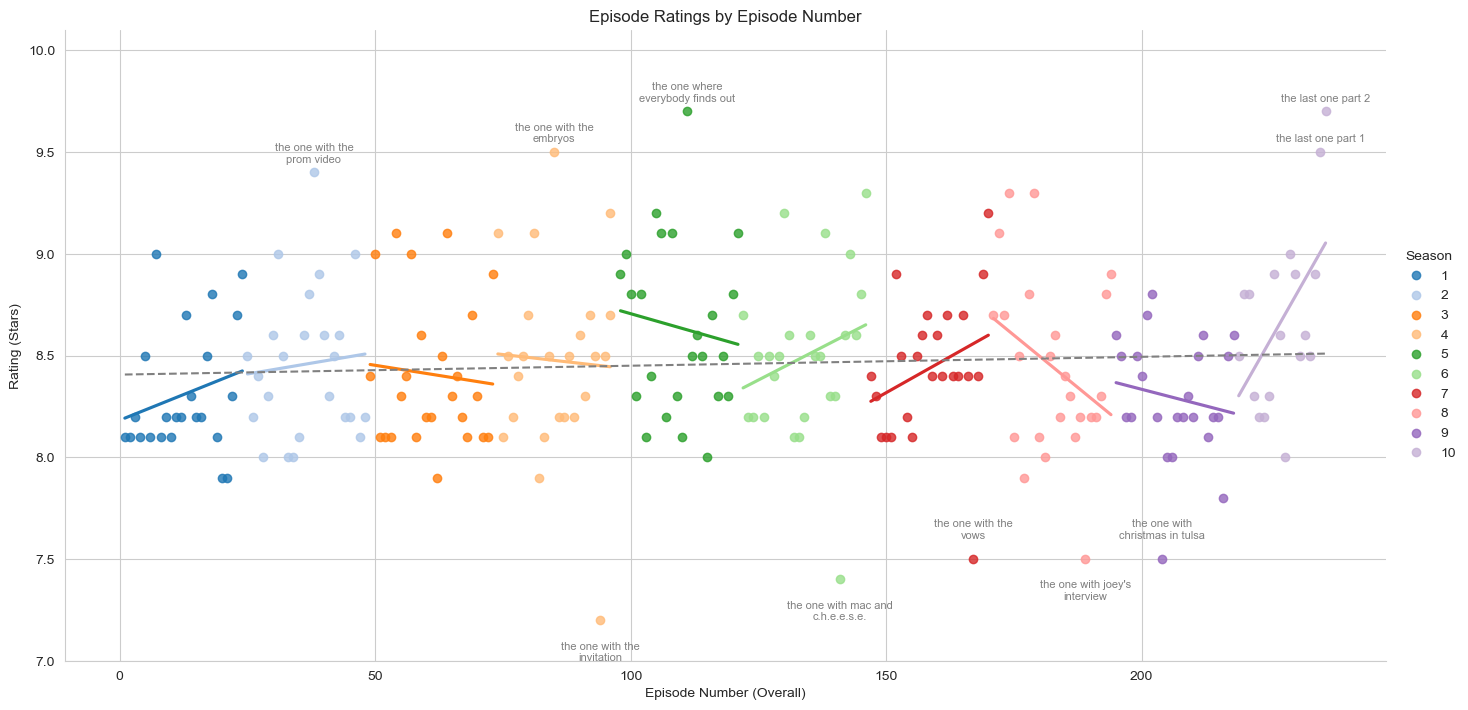

In [23]:
# Set plot size and style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Scatter plot of ratings by episode, colored by season
sns.lmplot(data=ep_data, x='episode_num_overall', y='Stars', hue='Season', palette='tab20', height=7, aspect=2, ci=None)

# Adding an overall trend line
sns.regplot(data=ep_data, x='episode_num_overall', y='Stars', scatter=False, color='grey', line_kws={"linestyle": "--", "linewidth": 1.5}, label='Overall Trend', ci=None)

# Customize the plot
plt.ylim(7, 10.1)
plt.title('Episode Ratings by Episode Number')
plt.xlabel('Episode Number (Overall)')
plt.ylabel('Rating (Stars)')

# Annotate the top 5 episodes with wrapped text
for _, row in top_5_episodes.iterrows():
    plt.text(row['episode_num_overall'], row['Stars'] + 0.05,
             wrap_text(row['Episode_Title']),
             ha='center', color='grey', fontsize=8)

# Annotate the bottom 5 episodes with wrapped text and different y-offsets for readability
for i, (_, row) in enumerate(bottom_5_episodes.iterrows(), start=1):
    # Place the fourth title above its point, others below for readability
    if i == 3 or i == 5:
        y_offset = 0.1
    else:
        y_offset = -0.2
    plt.text(row['episode_num_overall'], row['Stars'] + y_offset,
             wrap_text(row['Episode_Title']),
             ha='center', color="grey", fontsize=8)
# Show plot
plt.show()

Episode rating vs. number of lines per character

In [24]:
# Transform lines_vs_scenes for joining with ep_data

pivoted_lines_vs_scenes = lines_vs_scenes.pivot_table(index=['Season', 'Episode'],
                            columns='Character',
                            values=['Lines', 'Scene Count'],
                            aggfunc='first').reset_index()

In [25]:
ep_data.rename(columns={'episode_num_in_season': 'Episode'}, inplace=True)

In [26]:
pivoted_lines_vs_scenes_sorted = pivoted_lines_vs_scenes.sort_values(by=['Season', 'Episode'])
ep_data_sorted = ep_data.sort_values(by=['Season', 'Episode'])

In [27]:
# Concat both databases
merged_data = pd.concat([pivoted_lines_vs_scenes_sorted, ep_data_sorted], axis=1)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import shap
import scipy

In [29]:
# Preparing the data

data_analysis = merged_data.drop(columns=['episode_num_overall', 'Episode', 'Summary', 'original_air_date', 'Episode_Title', 'Stars_avg', ('Season', ''), ('Episode', ''), 'Votes']) # Changed "('Season', '')" and "('Episode', '')" to reflect actual column names from error message
data_analysis = data_analysis.dropna()
data_analysis.columns = data_analysis.columns.map(str)

In [30]:
# Encode categorical columns
categorical_features = ['Director', 'written_by']
numeric_features = data_analysis.drop(columns=['Director', 'written_by', 'Stars']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

In [31]:
X = data_analysis.drop(columns=['Stars'])
y = data_analysis['Stars']

# Split the data & Run the Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', RandomForestRegressor(random_state=42))])

In [32]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.1739916875000006


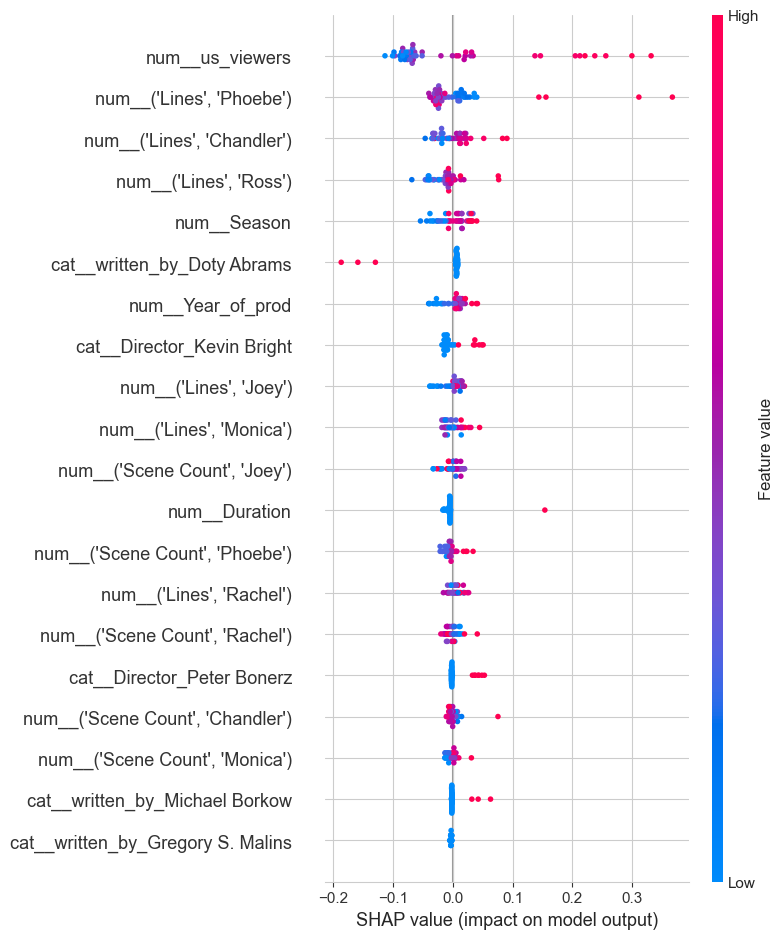

In [33]:
# Interpret results with SHAP
explainer = shap.TreeExplainer(pipeline['model'])
# Convert the transformed data to a dense numpy array with numeric dtype
#If preprocessor.transform(X_test) is a sparse matrix, convert to dense
X_test_transformed = preprocessor.transform(X_test)
if isinstance(X_test_transformed, scipy.sparse.spmatrix):
    X_test_transformed = X_test_transformed.toarray()
X_test_transformed = X_test_transformed.astype(np.float64)
#Ensure the data type is suitable for shap_values

shap_values = explainer.shap_values(X_test_transformed)

# Get feature names after one-hot encoding
# Assuming preprocessor is your ColumnTransformer object
feature_names = preprocessor.get_feature_names_out()

shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)